In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('./input/train.csv')

print('train.shape:', train.shape)
train.head()

train.shape: (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
test = pd.read_csv('./input/test.csv')

print('test.shape:', test.shape)
test.head()

test.shape: (153164, 2)


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


# Check null

In [4]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
test.isnull().sum()

id              0
comment_text    0
dtype: int64

# Class Distribution

In [6]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[classes]

In [7]:
print('y_train.shape:', y_train.shape)
y_train.head()

y_train.shape: (159571, 6)


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [8]:
print('toxic:',y_train['toxic'].value_counts()[1], '       ', '{:.2f}'.format(y_train['toxic'].value_counts()[1]/len(y_train)*100), '%')
print('severe_toxic:',y_train['severe_toxic'].value_counts()[1], ' ', '{:.2f}'.format(y_train['severe_toxic'].value_counts()[1]/len(y_train)*100), '%')
print('obscene:',y_train['obscene'].value_counts()[1], '      ', '{:.2f}'.format(y_train['obscene'].value_counts()[1]/len(y_train)*100), '%')
print('threat:',y_train['threat'].value_counts()[1], '        ', '{:.2f}'.format(y_train['threat'].value_counts()[1]/len(y_train)*100), '%')
print('insult:',y_train['insult'].value_counts()[1], '       ', '{:.2f}'.format(y_train['insult'].value_counts()[1]/len(y_train)*100), '%')
print('identity_hate:',y_train['identity_hate'].value_counts()[1], '', '{:.2f}'.format(y_train['identity_hate'].value_counts()[1]/len(y_train)*100), '%')

toxic: 15294         9.58 %
severe_toxic: 1595   1.00 %
obscene: 8449        5.29 %
threat: 478          0.30 %
insult: 7877         4.94 %
identity_hate: 1405  0.88 %


# Text Cleaning

In [9]:
# Tools for text preprocessing
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

def review_to_words( raw_review ):
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text() 
    
    # 2. Remove non-letters with regex
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                           
    
    # 4. Create set of stopwords
    stops = set(stopwords.words("english"))                  
    
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

In [10]:
x_train = train['comment_text'].apply(review_to_words)
x_test = test['comment_text'].apply(review_to_words)

D:\Anaconda3\envs\tensorflow\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
D:\Anaconda3\envs\tensorflow\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
D:\Anaconda3\envs\tensorflow\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://en.wikipedia.org/wiki/Wikipedia:ELYES" looks like a URL. Beautiful So

In [11]:
x_train.head()

0    explanation edits made username hardcore metal...
1    aww matches background colour seemingly stuck ...
2    hey man really trying edit war guy constantly ...
3    make real suggestions improvement wondered sec...
4                        sir hero chance remember page
Name: comment_text, dtype: object

In [12]:
x_test.head()

0    yo bitch ja rule succesful ever whats hating s...
1                                   rfc title fine imo
2                          sources zawe ashton lapland
3    look back source information updated correct f...
4                            anonymously edit articles
Name: comment_text, dtype: object

# 1) Tokenization
1. Tokenization - We need to break down the sentence into unique words. 
    For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
2. Indexing - We put the words in a dictionary-like structure and give them an index each
    For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}
3. Index Representation- We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM.
    For eg, [1,2,3,4,2,5] 

In [13]:
max_features = 20000   # how many unique words to use (i.e num rows in embedding vector)

In [14]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = max_features)

# Create a dictionary e.g. {'angry': 3, 'excited': 5, 'a': 1}
tokenizer.fit_on_texts(list(x_train))   

# Convert texts to int
x_train_tokenized = tokenizer.texts_to_sequences(x_train)
x_test_tokenized = tokenizer.texts_to_sequences(x_test)

Using TensorFlow backend.
D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\fra

In [15]:
tokenizer.word_index

{'article': 1,
 'wikipedia': 2,
 'page': 3,
 'talk': 4,
 'please': 5,
 'would': 6,
 'one': 7,
 'like': 8,
 'see': 9,
 'also': 10,
 'think': 11,
 'know': 12,
 'people': 13,
 'edit': 14,
 'articles': 15,
 'use': 16,
 'time': 17,
 'may': 18,
 'user': 19,
 'thanks': 20,
 'even': 21,
 'get': 22,
 'make': 23,
 'good': 24,
 'well': 25,
 'information': 26,
 'could': 27,
 'want': 28,
 'deletion': 29,
 'sources': 30,
 'way': 31,
 'name': 32,
 'image': 33,
 'first': 34,
 'wp': 35,
 'help': 36,
 'pages': 37,
 'new': 38,
 'source': 39,
 'editing': 40,
 'go': 41,
 'section': 42,
 'need': 43,
 'say': 44,
 'fuck': 45,
 'edits': 46,
 'thank': 47,
 'made': 48,
 'many': 49,
 'much': 50,
 'used': 51,
 'really': 52,
 'discussion': 53,
 'deleted': 54,
 'find': 55,
 'work': 56,
 'since': 57,
 'right': 58,
 'point': 59,
 'add': 60,
 'read': 61,
 'look': 62,
 'someone': 63,
 'wiki': 64,
 'take': 65,
 'two': 66,
 'still': 67,
 'back': 68,
 'fact': 69,
 'hi': 70,
 'list': 71,
 'link': 72,
 'said': 73,
 'somethin

In [16]:
len(tokenizer.word_index)

168663

In [17]:
print('len(x_train_tokenized):', len(x_train_tokenized))
x_train_tokenized

len(x_train_tokenized): 159571


[[532,
  46,
  48,
  521,
  4116,
  10690,
  862,
  215,
  10866,
  6374,
  2494,
  2672,
  38,
  1021,
  14499,
  2533,
  5,
  134,
  242,
  4,
  3,
  57,
  3084],
 [15745, 2369, 419, 3471, 4168, 2458, 20, 4, 810, 84],
 [283,
  293,
  52,
  140,
  14,
  197,
  456,
  2048,
  364,
  375,
  26,
  464,
  46,
  241,
  4,
  3,
  108,
  305,
  2142,
  581,
  341],
 [23,
  213,
  1248,
  1878,
  5548,
  42,
  2237,
  383,
  3886,
  1126,
  8987,
  11,
  164,
  18,
  43,
  12653,
  1272,
  1068,
  1867,
  295,
  1068,
  205,
  383,
  7,
  177,
  34,
  4014,
  2142,
  162,
  164,
  28,
  5,
  103,
  12,
  410,
  5482,
  15,
  260,
  491,
  18,
  1799,
  2665,
  2956,
  296,
  375,
  488,
  3268,
  2,
  24,
  1,
  3241,
  4461],
 [1468, 3131, 893, 440, 3],
 [2412, 25, 16, 1995, 25, 4],
 [1657, 3152, 209, 56],
 [99, 3119, 1, 215, 5, 506],
 [152,
  172,
  618,
  1281,
  361,
  8675,
  216,
  113,
  1,
  1279,
  6,
  2623,
  99,
  873,
  886,
  1196,
  7,
  16,
  340,
  161,
  4419,
  7560,
  3,
 

In [18]:
totalNumWords = [len(one_comment) for one_comment in x_train_tokenized]
totalNumWords

[23,
 10,
 21,
 52,
 5,
 6,
 4,
 6,
 38,
 3,
 253,
 5,
 26,
 65,
 15,
 47,
 7,
 3,
 9,
 31,
 21,
 4,
 44,
 8,
 119,
 7,
 25,
 24,
 9,
 7,
 8,
 5,
 7,
 85,
 21,
 64,
 98,
 29,
 13,
 94,
 21,
 19,
 50,
 5,
 24,
 57,
 5,
 9,
 58,
 95,
 244,
 13,
 14,
 50,
 5,
 13,
 6,
 58,
 161,
 28,
 11,
 28,
 5,
 82,
 15,
 25,
 8,
 12,
 20,
 11,
 13,
 28,
 4,
 111,
 15,
 4,
 20,
 22,
 17,
 8,
 88,
 225,
 48,
 25,
 10,
 7,
 7,
 5,
 28,
 2,
 67,
 38,
 6,
 10,
 39,
 55,
 7,
 10,
 16,
 17,
 6,
 20,
 7,
 35,
 7,
 5,
 67,
 51,
 10,
 16,
 8,
 5,
 57,
 37,
 116,
 7,
 47,
 26,
 25,
 4,
 20,
 17,
 20,
 18,
 9,
 13,
 241,
 15,
 20,
 43,
 19,
 13,
 28,
 16,
 57,
 15,
 8,
 19,
 2,
 5,
 77,
 41,
 160,
 29,
 9,
 66,
 5,
 21,
 31,
 37,
 66,
 40,
 5,
 43,
 8,
 21,
 11,
 30,
 17,
 8,
 318,
 21,
 219,
 6,
 12,
 16,
 54,
 59,
 10,
 26,
 22,
 5,
 34,
 3,
 12,
 2,
 10,
 1,
 8,
 63,
 80,
 5,
 5,
 30,
 8,
 8,
 10,
 8,
 33,
 15,
 24,
 25,
 24,
 3,
 6,
 21,
 19,
 43,
 40,
 11,
 51,
 31,
 10,
 24,
 49,
 26,
 45,
 37,
 9,
 6,
 8,


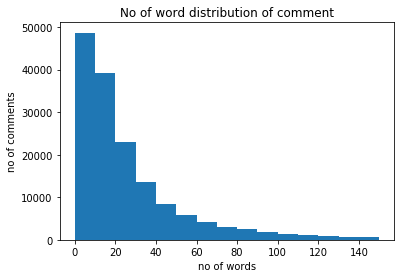

Total comments = 159571


In [19]:
totalNumWords = [len(one_sentence) for one_sentence in x_train_tokenized]
plt.hist(totalNumWords, bins = np.arange(0,160,10))
plt.xlabel("no of words")
plt.ylabel("no of comments")
plt.title("No of word distribution of comment")
plt.show()
print("Total comments =", len(x_train_tokenized))

# 2) Padding

In [20]:
maxlen = 80   # max number of words in a comment

In [21]:
# Padding (making every comments in same length)

from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train_tokenized, maxlen = maxlen)
x_test = pad_sequences(x_test_tokenized, maxlen = maxlen)

In [22]:
print('len(x_train):', len(x_train))
x_train

len(x_train): 159571


array([[    0,     0,     0, ...,     3,    57,  3084],
       [    0,     0,     0, ...,     4,   810,    84],
       [    0,     0,     0, ...,  2142,   581,   341],
       ...,
       [    0,     0,     0, ...,  3155, 12549,  4037],
       [    0,     0,     0, ...,   268,    54,    62],
       [    0,     0,     0, ...,   241,  1425,  1827]])

# Glove: pre-trained word vector

Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

In [23]:
embedding_file='./input/glove6b50d/glove.6B.50d.txt'

In [24]:
embed_size = 50   # no. of embedding vector dimensions

In [25]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file, encoding="utf-8"))

Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

In [26]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

D:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3214: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (yield from self.run_code(code, result)):


(0.020940498, 0.6441043)

In [27]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
print('embedding_matrix.shape:', embedding_matrix.shape)
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

embedding_matrix.shape: (20000, 50)


# Split training and valdiation set

In [28]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=985236)

# Model

In [29]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [33]:
# embed_size = 128   # no. of embedding vector dimensions
KEEP_PROB = 0.25

In [34]:
def create_model ():
    
    inputs = Input(shape=(maxlen, ))             #80     # max number of words in a comment (word index)
    
#     # Without using Glove
#     x = Embedding(input_dim = max_features,      #20000  # how many unique words to use (i.e num rows in embedding vector)
#                   output_dim = embed_size,       #128    # no. of embedding vector dimensions
#                   )(inputs)                              # output_dim of embedding layer: (80,128) <- word vector

    # Using Glove pretrained embedding matrix
    x = Embedding(input_dim = max_features,
                  output_dim = embed_size, 
                  weights=[embedding_matrix])(inputs)
    
    x = Bidirectional(LSTM(60, return_sequences=True, dropout=KEEP_PROB, recurrent_dropout=KEEP_PROB))(x)   # each LSTM cell (80) has 60 hidden units (output), Therefore, output_dim=(80,60)
    
    x = GlobalMaxPool1D()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(KEEP_PROB)(x)
    outputs = Dense(6, activation="sigmoid")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

![](https://i.imgur.com/txJomEa.png)

In [35]:
model = create_model()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 120)           53280     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6050      
________________________________________________________________

In [36]:
BATCH_SIZE = 2048
EPOCHS = 5

In [37]:
history = model.fit(x = x_train,
                    y = y_train, 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE,
                    validation_data = (x_val, y_val))

Train on 143613 samples, validate on 15958 samples
Epoch 1/5
143613/143613 [==============================] - 27s 187us/step - loss: 0.2738 - acc: 0.8987 - val_loss: 0.1218 - val_acc: 0.9650
Epoch 2/5
143613/143613 [==============================] - 25s 175us/step - loss: 0.1147 - acc: 0.9649 - val_loss: 0.0749 - val_acc: 0.9731
Epoch 3/5
143613/143613 [==============================] - 28s 195us/step - loss: 0.0767 - acc: 0.9746 - val_loss: 0.0586 - val_acc: 0.9800
Epoch 4/5
143613/143613 [==============================] - 25s 174us/step - loss: 0.0636 - acc: 0.9782 - val_loss: 0.0542 - val_acc: 0.9810
Epoch 5/5
143613/143613 [==============================] - 24s 170us/step - loss: 0.0584 - acc: 0.9797 - val_loss: 0.0519 - val_acc: 0.9813


In [38]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


# Model Evaluation (df_train)

## 1) Plot loss and accuracy

In [39]:
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    
    ax[0].legend()
    ax[1].legend()

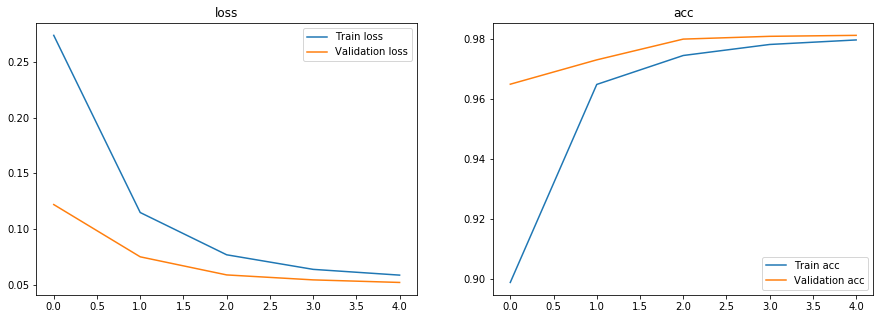

In [40]:
show_history(history)

## 2) Loss and accuracy on validation set

In [41]:
score = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE)
print("loss:", score[0])
print("metric (accuracy): ", score[1])

15958/15958 [==============================] - 1s 66us/step
loss: 0.05187370885793376
metric (accuracy):  0.9812841895962586


## 3) ROC AUC

In [42]:
y_val_pred = model.predict(x_val,
                           batch_size = BATCH_SIZE)

In [43]:
from sklearn.metrics import roc_auc_score

print('ROC AUC (val): {0}'.format(roc_auc_score(y_val, y_val_pred)))

ROC AUC (val): 0.9718953865941319


# Prediction

In [44]:
y_test = model.predict(x_test,
                       batch_size = BATCH_SIZE)

In [45]:
y_test

array([[9.2890561e-01, 2.1646199e-01, 8.4453970e-01, 3.5738915e-02,
        7.9888606e-01, 1.8090644e-01],
       [9.7950101e-03, 1.2519956e-04, 1.1888146e-03, 3.8474798e-04,
        2.5619268e-03, 8.5914135e-04],
       [2.1530896e-02, 4.1204691e-04, 2.6116073e-03, 9.4348192e-04,
        6.0070455e-03, 1.8670559e-03],
       ...,
       [5.4585934e-04, 3.0994415e-06, 4.3630600e-05, 1.3023615e-05,
        1.5604496e-04, 4.6998262e-05],
       [1.7787516e-03, 1.8417835e-05, 2.0268559e-04, 6.5237284e-05,
        6.3419342e-04, 2.0492077e-04],
       [9.0945393e-01, 8.5374713e-02, 6.8653679e-01, 2.6215017e-02,
        5.7624751e-01, 6.9266677e-02]], dtype=float32)

# Submission

In [46]:
sample_submission = pd.read_csv('./input/sample_submission.csv')

print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

sample_submission.shape: (153164, 7)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [47]:
sample_submission[classes] = y_test
sample_submission.to_csv('./output/submission.csv', index=False)

# Save model architecture (.json) and model weights (.h5)

In [48]:
# Save model architecture (.json)

model_json = model.to_json()
with open("./model/modelarchitecture.json", "w") as json_file:
    json_file.write(model_json)

In [49]:
# Save model weights (.h5)

model.save_weights("./model/modelweights.h5")

# Plot Model png

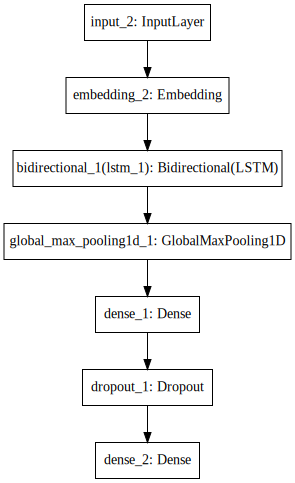

In [50]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='./model/model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))